In [13]:
# I/O
import os
# data manipulation
import numpy as np
import pandas as pd
# audio analysis
import librosa
import librosa.display
# noise reducer
import noisereduce as nr
# printing results and listening
import matplotlib.pyplot as plt
import IPython.display as ipd
# progress bar
from tqdm.notebook import tqdm_notebook

# Dataset Loading

Let's load all the paths of .wav files in a pandas DataFrame along their label and some additional information likes sampling rate, number of frames, lenght in ms (as 1000*number_of_frames/sampling_rate) to further load and processing steps

In [2]:
dir_data = "./Labelled/"
labels = "Bleatings ContactCalls Others".split()

In [3]:
data_to_load = []
for l in tqdm_notebook(labels):
    for filename in tqdm_notebook(os.listdir(f'{dir_data}{l}')):
        path = f'{dir_data}{l}/{filename}'
        sample, sampling_rate = librosa.load(path, sr=None, mono=True)
        len_sample = len(sample)
        duration_sample = 1000*len_sample/sampling_rate
        data_to_load.append((path, l, sampling_rate, len_sample, duration_sample))
data_to_load = pd.DataFrame(data_to_load, columns=["path", "label", "samplingrate", "nframes", "ms"])
data_to_load

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/350 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/401 [00:00<?, ?it/s]

path      label  \
0    ./Labelled/Bleatings/evt_000_000_000681_210415...  Bleatings   
1    ./Labelled/Bleatings/evt_000_000_000682_210415...  Bleatings   
2    ./Labelled/Bleatings/evt_000_000_000683_210415...  Bleatings   
3    ./Labelled/Bleatings/evt_000_000_000684_210415...  Bleatings   
4    ./Labelled/Bleatings/evt_000_000_002434_210416...  Bleatings   
..                                                 ...        ...   
822  ./Labelled/Others/evt_003_003_069816_210609_06...     Others   
823  ./Labelled/Others/evt_003_003_069817_210609_06...     Others   
824  ./Labelled/Others/evt_003_003_069818_210609_06...     Others   
825  ./Labelled/Others/evt_003_003_069819_210609_06...     Others   
826  ./Labelled/Others/evt_003_003_069820_210609_06...     Others   

     samplingrate  nframes       ms  
0           16000   156016   9751.0  
1           16000    99040   6190.0  
2           16000    97152   6072.0  
3           16000    97696   6106.0  
4           16000   164224  10264.0  
..            ...      ...      ...  
822         16000   228400  14275.0  
823         16000    97568   6098.0  
824         16000   119280   7455.0  
825         16000    96448   6028.0  
826         16000   205648  12853.0  

[827 rows x 5 columns]

Save the results of the analysis for further computation.

In [162]:
data_to_load.to_csv("to_load.csv", index=False)

# General analysis of data

### Sampling rate

Check that the sampling rate is equal in all the records

In [98]:
data_to_load['samplingrate'].value_counts().to_frame()

samplingrate
16000           827

All the records have the same sampling rate

### Samples for class

Let's look at how many samples we have for each class

label
Others          401
Bleatings       350
ContactCalls     76

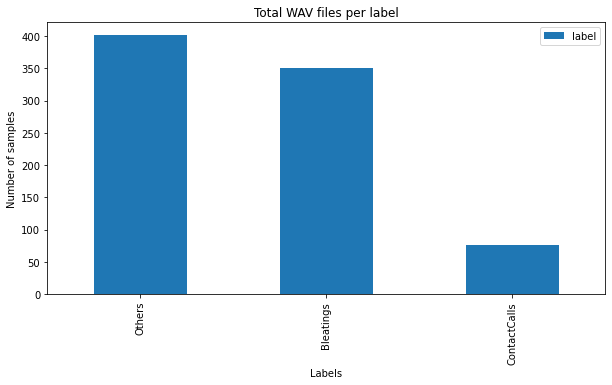

In [4]:
count_label = data_to_load['label'].value_counts().to_frame()
ax = count_label.plot(kind="bar", title='Total WAV files per label', figsize=(10,5))
ax.set_xlabel("Labels")
ax.set_ylabel("Number of samples")
count_label

As we can see the dataset is pretty imbalanced, in particular we have a fery few records for ContactCalls class. We must take care of this in the further steps.

### Lenght of the samples

Now let's focus on lenght of the sample. Let's extract some general information about the distribution and plot the histogram of the lengths.

count       827.000000
mean      13294.934704
std       12527.100962
min        6006.000000
25%        6250.000000
50%        8658.000000
75%       14137.000000
max      126324.000000
Name: ms, dtype: float64

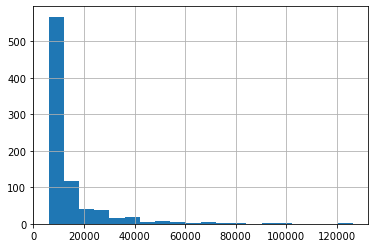

In [156]:
durations = data_to_load['ms']
durations.hist(bins=20)
durations.describe()

The most of the records are < 20 seconds but there are some that are well above the minute, as reported in max. Let's see how many of these we have.

In [154]:
len(durations>60000])

11

Since all the audio samples need to be of the same lenght for the analysis that i want to conduce let's consider as hypothetic threshold value 20s 

label
Bleatings        55
Others           41
ContactCalls     30

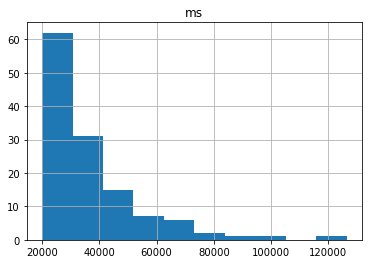

In [157]:
import seaborn as sns
above20s = data_to_load[durations>20000]
count_label = above20s["label"].value_counts().to_frame()
lengths = above20s['ms'].to_frame()
lengths.hist()
count_label

# Basic audio analysis

Let's load the first sample with IPython.display module, along its amplitude of the waveform

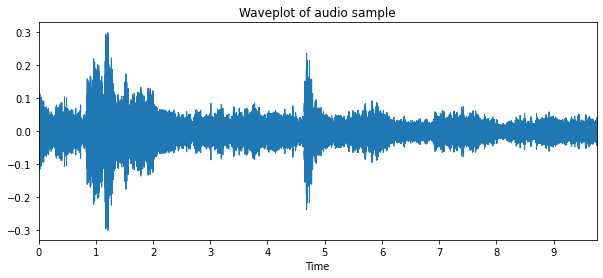

In [117]:
sample1, sr1 = librosa.load(data_to_load.iloc[0]["path"], sr=None)

def wave_and_audio(sample, sr):
    # plot the signal
    plt.figure(figsize=(10, 4))
    librosa.display.waveplot(sample, sr=sr)
    plt.title('Waveplot of audio sample')
    plt.show()
    # reproduce the sample
    ipd.display(ipd.Audio(sample, rate=sr))
    
wave_and_audio(sample1,sr1)

## MFCCs adn delta MFCCs

To train one of the choosen models i've decided to extract MFCCs

In [15]:
mfccs = librosa.feature.mfcc(sample1, sr = sr1, n_mfcc=20)
np.shape(mfccs)

(20, 305)

We have found the values for all the passed number of MFFCCs in any segment of the sample. We can now sum up the data by taking the mean, standard deviation, maximum, median and minimum of each coefficient over time.

In [16]:
mfccs_trunc = (np.mean(mfccs, axis=1), np.std(mfccs, axis=1), np.max(mfccs, axis = 1), np.median(mfccs, axis = 1),
               np.min(mfccs, axis = 1))
mfccs_trunc

(array([-2.1586108e+02,  1.0883392e+02, -3.5260464e+01,  2.5991604e+01,
        -8.1914186e+00, -2.9531810e-01, -8.6178708e-01, -1.5107145e+00,
        -8.7174273e-01, -7.4528199e-01, -1.5428183e+00,  4.2711940e+00,
        -1.3264749e+00, -1.9845957e-02,  3.9359527e+00,  1.9444271e+00,
        -6.7978096e-01,  9.5162213e-01, -4.1913098e-01,  1.6591432e+00],
       dtype=float32),
 array([51.429268 , 11.377387 , 11.696471 ,  8.783739 ,  7.307996 ,
         6.790985 ,  6.897165 ,  4.9523673,  5.15034  ,  5.123374 ,
         4.867278 ,  6.310449 ,  5.2349534,  4.091109 ,  4.772597 ,
         4.413325 ,  4.382633 ,  4.5159163,  3.9068701,  4.7059255],
       dtype=float32),
 array([-36.66912  , 153.79199  ,  -1.6029059,  61.723396 ,  10.794336 ,
         16.428951 ,  21.416553 ,  13.464827 ,  16.084429 ,  14.317383 ,
         14.635578 ,  25.934135 ,  12.310995 ,  12.018374 ,  17.899529 ,
         16.362675 ,  12.023514 ,  15.776964 ,  10.699522 ,  16.311852 ],
       dtype=float32),
 arr

And now we can stack all the features in a single row

In [17]:
mfccs_trunc = np.hstack(mfccs_trunc)
np.shape(mfccs_trunc)

(100,)

As done before now we can extract delta MFCCs and process the coefficients as before to extract time based statistics of the feature

In [18]:
mfccs_delta = librosa.feature.delta(mfccs)
np.shape(mfccs_delta)

(20, 305)

In [19]:
mfccs_delta_trunc = (np.mean(mfccs_delta, axis=1), np.std(mfccs_delta, axis=1), np.max(mfccs_delta, axis = 1)
                     , np.median(mfccs_delta, axis = 1), np.min(mfccs_delta, axis = 1))
mfccs_delta_trunc = np.hstack(mfccs_trunc)
np.shape(mfccs_delta_trunc)

(100,)

And finally combine the result from MFCCs and delta-MFCCs computations.

In [20]:
features_set = np.concatenate((mfccs_trunc, mfccs_delta_trunc))
features_set

array([-2.15861084e+02,  1.08833923e+02, -3.52604637e+01,  2.59916039e+01,
       -8.19141865e+00, -2.95318097e-01, -8.61787081e-01, -1.51071453e+00,
       -8.71742725e-01, -7.45281994e-01, -1.54281831e+00,  4.27119398e+00,
       -1.32647491e+00, -1.98459569e-02,  3.93595266e+00,  1.94442713e+00,
       -6.79780960e-01,  9.51622128e-01, -4.19130981e-01,  1.65914321e+00,
        5.14292679e+01,  1.13773870e+01,  1.16964712e+01,  8.78373909e+00,
        7.30799580e+00,  6.79098511e+00,  6.89716482e+00,  4.95236731e+00,
        5.15034008e+00,  5.12337399e+00,  4.86727810e+00,  6.31044912e+00,
        5.23495340e+00,  4.09110880e+00,  4.77259684e+00,  4.41332483e+00,
        4.38263321e+00,  4.51591635e+00,  3.90687013e+00,  4.70592546e+00,
       -3.66691208e+01,  1.53791992e+02, -1.60290587e+00,  6.17233963e+01,
        1.07943363e+01,  1.64289513e+01,  2.14165535e+01,  1.34648266e+01,
        1.60844288e+01,  1.43173828e+01,  1.46355782e+01,  2.59341354e+01,
        1.23109951e+01,  

We can also print in a heatmap the MFCCS and delta-MFCSS

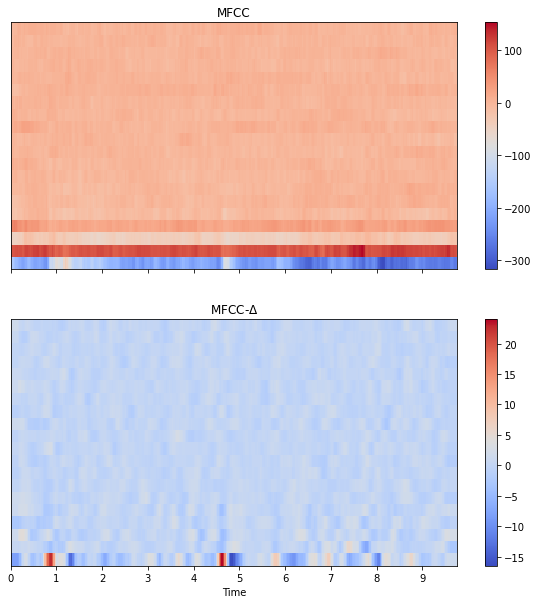

In [21]:
fig, ax = plt.subplots(nrows=2, sharex=True, sharey=True, figsize=(10,10))
img1 = librosa.display.specshow(mfccs, sr=sr1, ax=ax[0], x_axis='time')
ax[0].set(title='MFCC')
ax[0].label_outer()
img2 = librosa.display.specshow(mfccs_delta, sr=sr1, ax=ax[1], x_axis='time')
ax[1].set(title=r'MFCC-$\Delta$')
ax[1].label_outer()
fig.colorbar(img1, ax=[ax[0]])
fig.colorbar(img2, ax=[ax[1]])

## logMel spectrogram

Now let's look at how to obtain a logMel spectrogram of the sample. We can compute a mel-scaled spectrogram of the singal with <a href="https://librosa.org/doc/main/generated/librosa.feature.melspectrogram.html">this method<a/>.

(128, 153)

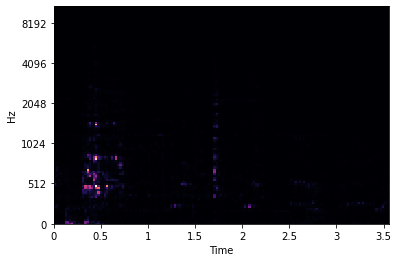

In [22]:
ps = librosa.feature.melspectrogram(y=sample1, sr=sr1, n_fft=2048, hop_length=1024)
librosa.display.specshow(ps, x_axis='time', y_axis='mel')
np.shape(ps)

That's good but most of the spectrogram is dark and not carrying enough useful information. So let’s modify it to use the Decibel Scale instead of Amplitude.

(128, 153)

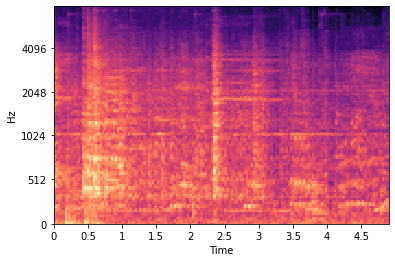

In [23]:
psdb = librosa.power_to_db(ps, ref=np.min)
librosa.display.specshow(psdb, sr=sr1, x_axis='time', y_axis='mel')
np.shape(psdb)

# Noise in data

Most of the samples have a bunch of background noise that pollute the singal. Let's see if we can remove some noise with the package <a href="https://pypi.org/project/noisereduce/">noisereducer</a>

Bleatings


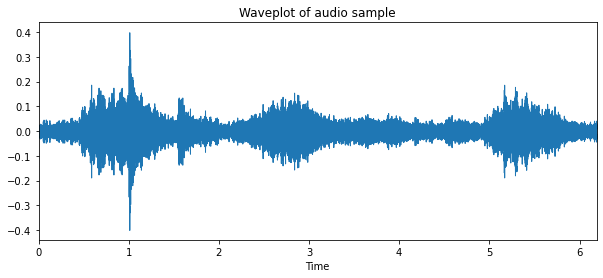

In [118]:
idx = 1
sample, sr = librosa.load(data_to_load.iloc[idx]["path"], sr=None)
print(data_to_load.iloc[idx]["label"])
wave_and_audio(sample, sr)

And apply to it the noise reduction algorithm

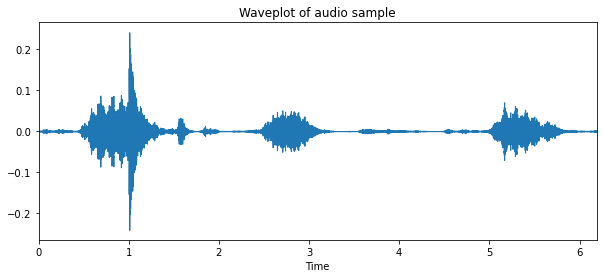

In [119]:
reduced_noise = nr.reduce_noise(y=sample, sr=sr)
wave_and_audio(reduced_noise, sr)

The techniques seems to works well. Let's test it on 2 sample for each class.

In [79]:
test_samples = []
for l in labels:
    extracted = data_to_load[data_to_load["label"] == l].sample(n=2).values.tolist()
    test_samples += extracted
test_samples = pd.DataFrame(test_samples, columns=["path", "label", "samplingrate", "nframes", "ms"])
test_samples

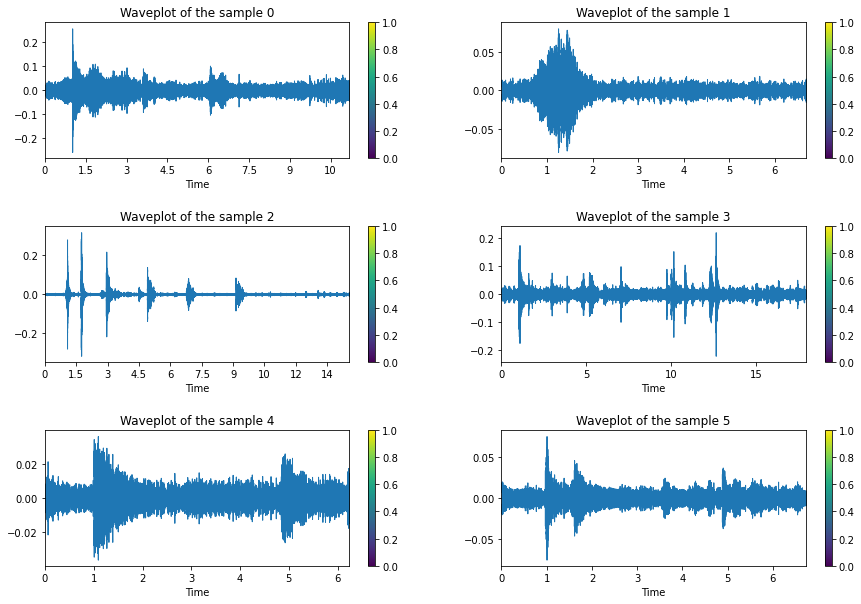

In [105]:
samples = [librosa.load(s[0], sr=None)[0] for s in test_samples.values.tolist()]

def plot_6samples(samples, rate):
    fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(15,10))
    ax = ax.ravel()
    fig.subplots_adjust(hspace = .5)
    for count, y in enumerate(samples):
        # plot the signal
        img = librosa.display.waveplot(y, sr=rate, ax=ax[count])
        ax[count].set_title(f'Waveplot of the sample {count}')
        fig.colorbar(img, ax=[ax[count]])
        # reproduce the signal
        ipd.display(ipd.Audio(y, rate=rate))
        
plot_6samples(samples, 16000)

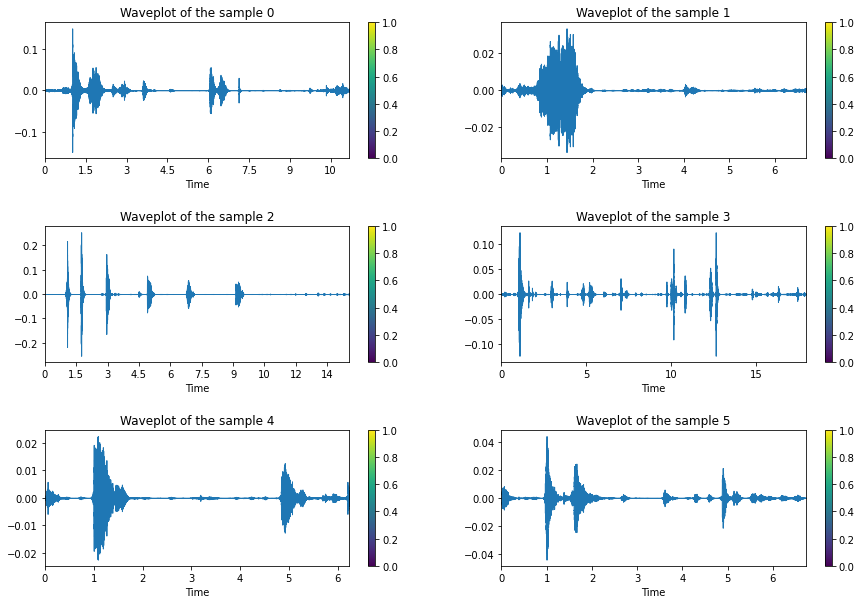

In [108]:
sample_denoise = [nr.reduce_noise(y=sample, sr=16000) for sample in samples]
plot_6samples(sample_denoise, 16000)

For sample 0 reduced from 179040 to 159808
For sample 1 reduced from 106960 to 28096
For sample 2 reduced from 232944 to 133440
For sample 3 reduced from 286544 to 263680
For sample 4 reduced from 99840 to 99584
For sample 5 reduced from 107696 to 79488


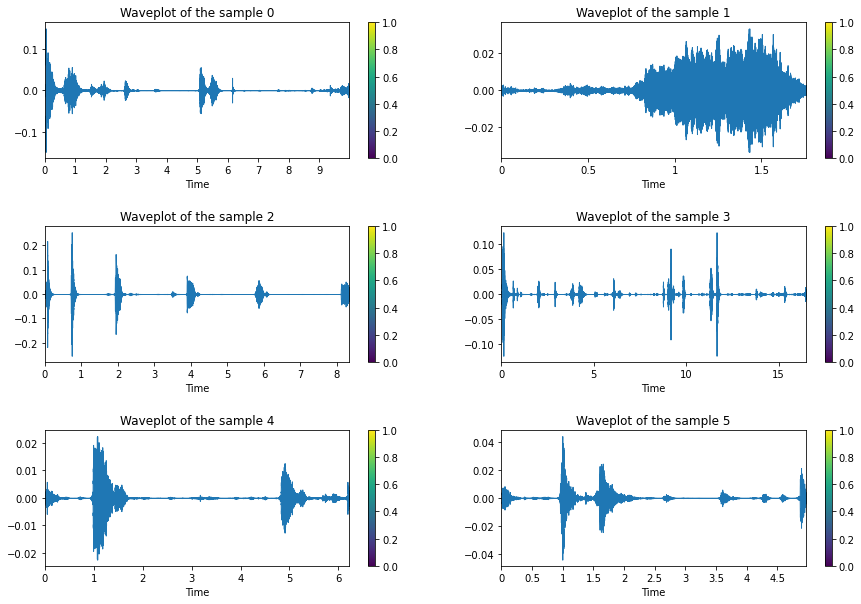

In [114]:
sample_denoise_trim = [librosa.effects.trim(sample, top_db=20, frame_length=512, hop_length=64)[0] for sample in sample_denoise]
plot_6samples(sample_denoise_trim, 16000)

for i in range(6):
    pre = len(sample_denoise[i]/16000)
    post = len(sample_denoise_trim[i]/16000)
    print(f'For sample {i} reduced from {pre} to {post}')